# Time Series Normalization

Normalizing a time series in relation to a set of other time series involves constructing a statistical model that connects the inputs and outputs, incorporating an additional numeric feature to represent time. This time feature accounts for the variations in the analyzed time series that cannot be explained by the input features, thus isolating the behavior of the analyzed time series from the influence of those input features.

## 1. How is time processed as a feature?

The time index is converted into a numeric feature in a straightforward manner: assigning 0 to the first timestamp and incrementing by 1 at a frequency defined by the user.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
original_freq = 'h'
time_index = pd.date_range(start='2024-01-01', freq=original_freq, periods=30*24)
time_index

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               ...
               '2024-01-30 14:00:00', '2024-01-30 15:00:00',
               '2024-01-30 16:00:00', '2024-01-30 17:00:00',
               '2024-01-30 18:00:00', '2024-01-30 19:00:00',
               '2024-01-30 20:00:00', '2024-01-30 21:00:00',
               '2024-01-30 22:00:00', '2024-01-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='h')

An hourly time index processed to a daily `freq_trend`:

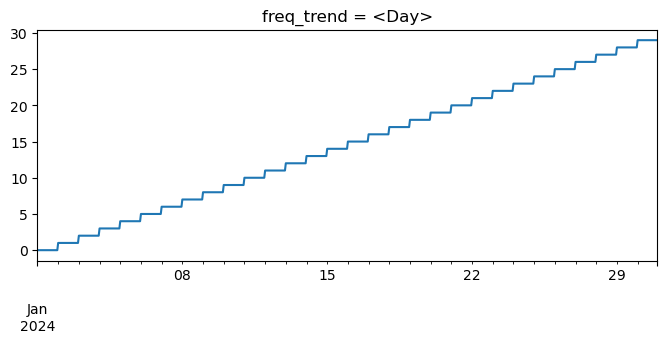

In [3]:
freq_trend = 'd'

freq_trend = pd.tseries.frequencies.to_offset(freq_trend)
time_numeric = (time_index - time_index.min()).floor(freq_trend) / freq_trend
time_numeric = pd.Series(time_numeric, index=time_index, name='time_numeric')

time_numeric.plot(figsize=(8, 3), title=f'freq_trend = {freq_trend}')
plt.show()

An hourly time index processed to a more customed `freq_trend`:

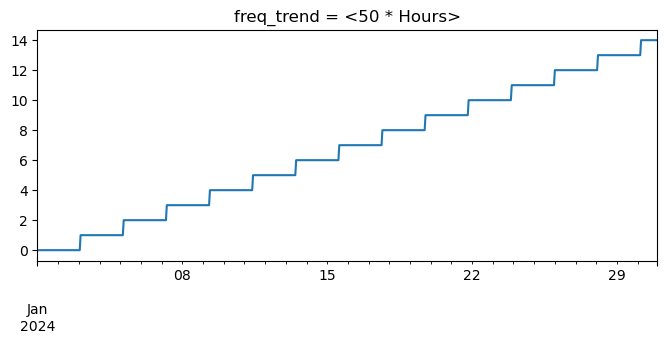

In [4]:
freq_trend = '50h'

freq_trend = pd.tseries.frequencies.to_offset(freq_trend)
time_numeric = (time_index - time_index.min()).floor(freq_trend) / freq_trend
time_numeric = pd.Series(time_numeric, index=time_index, name='time_numeric')

time_numeric.plot(figsize=(8, 3), title=f'freq_trend = {freq_trend}')
plt.show()

What does this entail? By adding the numeric time feature to the dataset, gradient boosting methods (or any tree-based methods) can partition the time dimension at any given node. For instance, if `time_numeric` is less than *x*, the model proceeds to the left child; otherwise, it goes to the right child. This allows the model to make different decisions based on time. Consequently, the statistical model can compute time-localized shifts to better capture variations in the output that cannot be explained by the other features.

To prevent overfitting, it is recommended to set the `freq_trend` to a value higher than the frequency of the original dataset.

## 2. Toy Dataset

Let’s generate a toy dataset:
- `a`: a time series
- `b`: a time series that is a function of `a`, with added noise, and then shifted by +0.4 during a specific time span
- `dummy`: a noise-only variable

When plotted, the shift is barely noticeable to the naked eye.

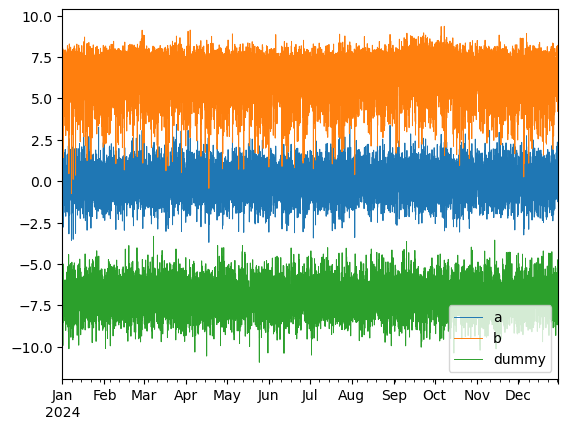

In [5]:
import numpy as np
from apyxl import XGBRegressorWrapper

n = 8760
time = pd.date_range(start='2024-01-01', freq='h', periods=n)


def f(x):
    return np.where(x >= 0, 0.5*x, 2*x)


a = np.random.randn(n)
b = 7 + f(a) + 0.3*np.random.randn(n)

df = np.c_[a, b]

# Shift time serie `b` on a continuous subset of the period
df[6000:7000, 1] += 0.4

df = pd.DataFrame(df, columns=['a', 'b'], index=time)
df['dummy'] = np.random.randn(n) - 7

df.plot(lw=0.7)
plt.show()

Let's construct `time_numeric` according to the process described earlier, with `freq_trend` set to one day:

C:\Users\jolyc\miniforge3\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jolyc\miniforge3\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


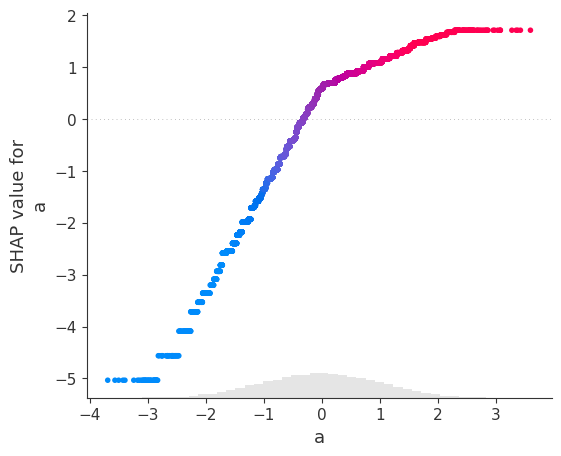

C:\Users\jolyc\miniforge3\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jolyc\miniforge3\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


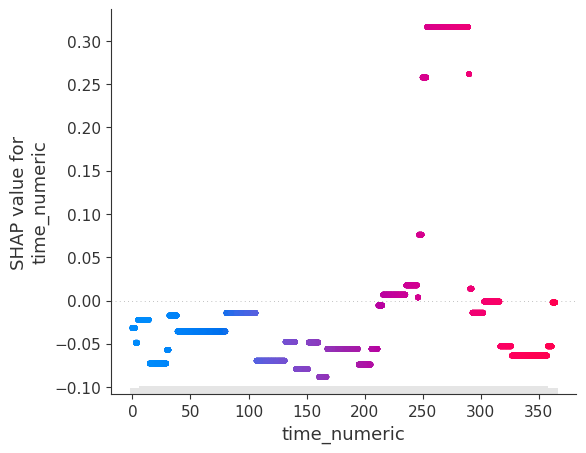

In [6]:
df['time_numeric'] = ((df.index - df.index.min())/pd.Timedelta(days=1)).astype(int)

# `apyxl` can be then used as:
target = 'b'
X, y = df.drop(columns=target), df[target]
model = XGBRegressorWrapper(random_state=0, max_evals=35).fit(X, y)
model.scatter(X, feature='a')
model.scatter(X, feature='time_numeric')

The fitted XGBoost regressor manages to capture the non-linear relationship between a and b (with the exception of extreme values) as well as the temporary, time-localized shift between the two time series. This trend, in other words the behavior of `b` that can't be explained by `a`, can be isolated:

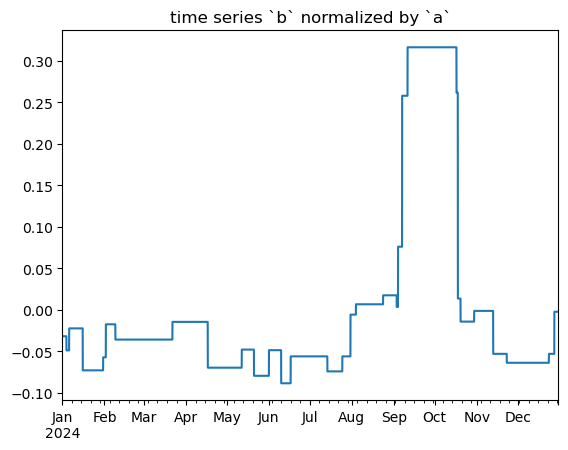

In [7]:
shap_values = model.compute_shap_values(X)
pd.Series(shap_values[:, 'time_numeric'].values, index=X.index).plot(title='time series `b` normalized by `a`')
plt.show()

The limited-time offset is clearly visible and has been discovered in an unsupervised manner. However, the trend is not noise-free, and some minor shifts may appear outside the actual one due to unavoidable overfitting.

### **3. Real-World Dataset**  

Let's explore what the methodology can produce as a normalized trend for a real-world dataset: French hourly electricity consumption from 2015 to mid-2020. We'll build the dataset in several steps:  

- **Downloading the time series to be normalized** via Kaggle: the data is sourced from [ENTSO-E Transparency Platform](https://transparency.entsoe.eu/).  
- **Downloading weather data across France** for the same period, using NOAA's ISD (Integrated Surface Database) via the package [isd-fetch](https://github.com/CyrilJl/isd-fetch).  
- **Reducing the weather dataset to quantiles**: For each considered field, such as temperature, the more than 300 time series won't be directly used as features. Instead, quantiles of the available values across France will be computed for each timestamp.  
- **Adding time-related features**, such as the month, weekday, and hour.  

Finally, we will demonstrate the use of `apyxl.TimeSeriesNormalizer` on this dataset.

In [8]:
from os.path import join

import kagglehub
from apyxl import TimeSeriesNormalizer
from pyisd import IsdLite

## 3.1. France's electricity consumption

Data provided by https://transparency.entsoe.eu/, downloaded via kaggle.

In [9]:
path = kagglehub.dataset_download("francoisraucent/western-europe-power-consumption")
load = pd.read_csv(join(path, 'fr.csv'), parse_dates=['start', 'end'], index_col='start').drop(columns='end')
load.index = load.index.tz_localize(None)
load.sample(3)

,load
start,
2016-08-23 23:00:00,41666.0
2020-07-18 09:00:00,44462.0
2017-07-26 12:00:00,51996.0


<Axes: xlabel='start'>

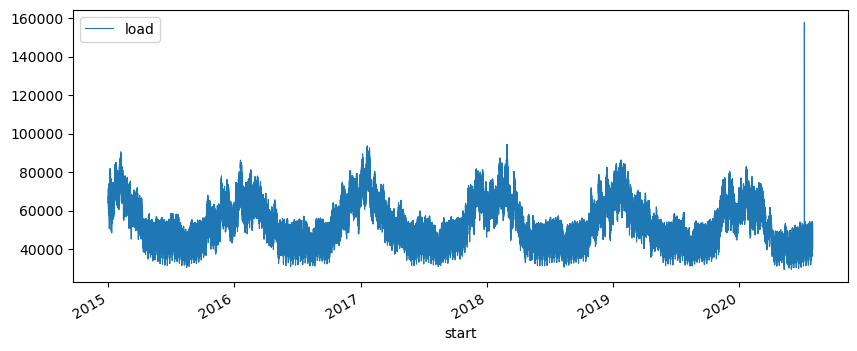

In [10]:
load.plot(figsize=(10, 4), lw=0.8)

## 3.2. Weather observations data

In [11]:
module = IsdLite(verbose=True)
data = module.get_data(start=load.index.min(), end=load.index.max(), countries='FR', organize_by='field')

  0%|          | 0/353 [00:00<?, ?it/s]

<Axes: >

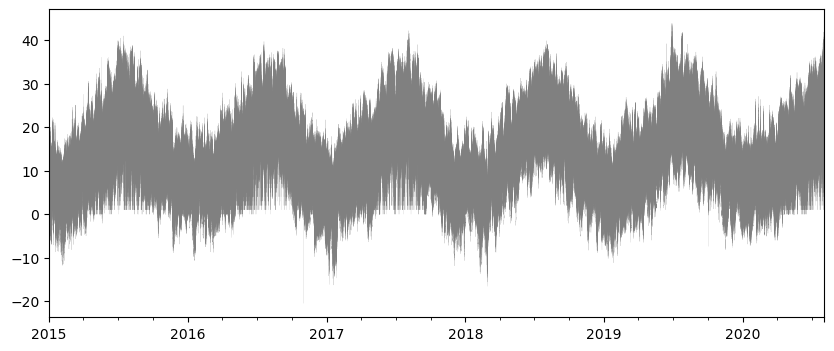

In [12]:
data['temp'].plot(legend=False, c='grey', lw=0.1, figsize=(10, 4))

In [13]:
data.keys()

dict_keys(['temp', 'dewtemp', 'pressure', 'winddirection', 'windspeed', 'skycoverage', 'precipitation-1h', 'precipitation-6h'])

## 3.3. Processing data for the normalization task

In [14]:
def quantiles(df, q, suffix=''):
    dfq = df.quantile(q=q, axis=1).T
    dfq.columns = [f'{suffix}_q{q_}' for q_ in q]
    return dfq

In [15]:
q = (0.01, 0.1, 0.25, 0.50, 0.75, 0.90, 0.99)
X = [load.copy()]
for field in ('temp', 'windspeed', 'skycoverage', 'precipitation-1h'):
    X.append(quantiles(df=data[field], q=q, suffix=field))
X = pd.concat(X, axis=1)
X['month'] = X.index.month
X['weekday'] = X.index.weekday
X['hour'] = X.index.hour
X.sample(3)

,load,temp_q0.01,temp_q0.1,temp_q0.25,temp_q0.5,temp_q0.75,temp_q0.9,temp_q0.99,windspeed_q0.01,windspeed_q0.1,...,precipitation-1h_q0.01,precipitation-1h_q0.1,precipitation-1h_q0.25,precipitation-1h_q0.5,precipitation-1h_q0.75,precipitation-1h_q0.9,precipitation-1h_q0.99,month,weekday,hour
2019-10-24 05:00:00,52113.0,8.568,10.47,11.200,12.2,13.100,14.73,19.263,0.0,1.0,...,-1.0,0.0,0.0,0.0,0.0,3.2,39.2,10,3,5
2018-03-16 00:00:00,56588.0,1.670,5.60,6.300,7.7,8.850,10.20,13.680,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4,0
2018-11-03 19:00:00,57805.0,1.168,4.17,5.475,7.4,10.425,14.53,19.498,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,5,19


## 3.4. Application of ``TimeSeriesNormalizer``

In [16]:
tsn = TimeSeriesNormalizer(freq_trend='7d')
trend, shap_values = tsn.normalize(X=X, target='load', return_shap_values=True, shift='auto')

<Axes: >

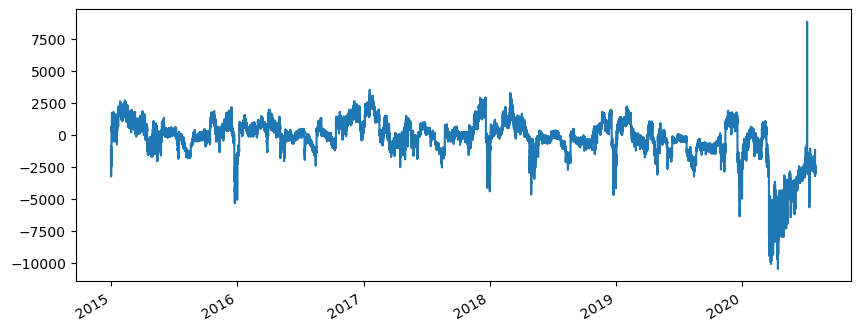

In [17]:
trend.plot(figsize=(10, 4))

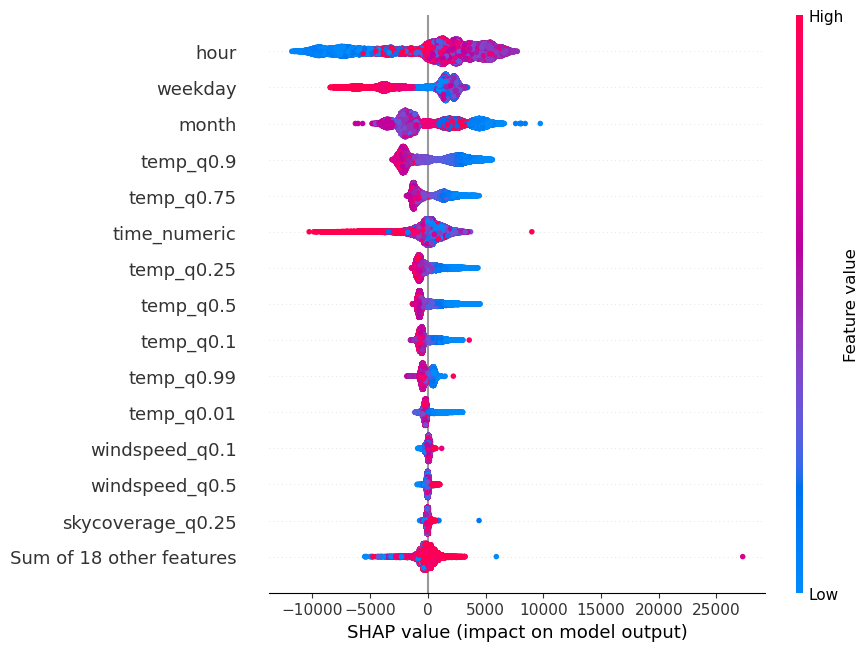

In [18]:
tsn.xgb.beeswarm(shap_values=shap_values, max_display=15)

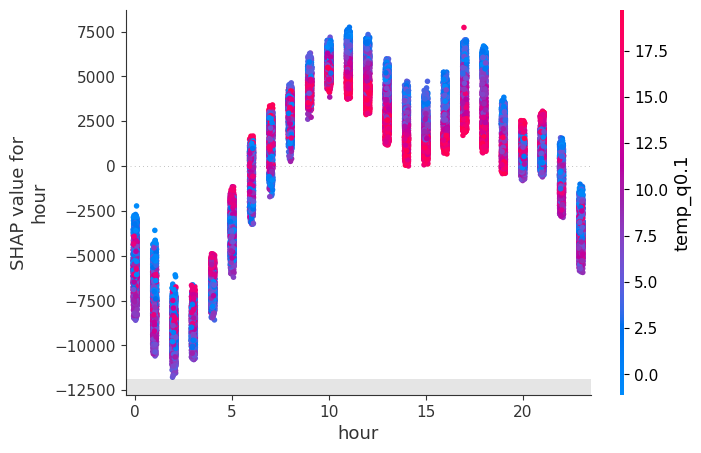

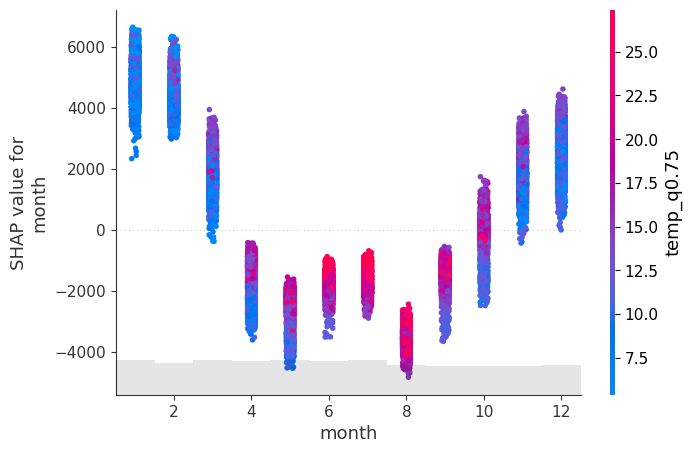

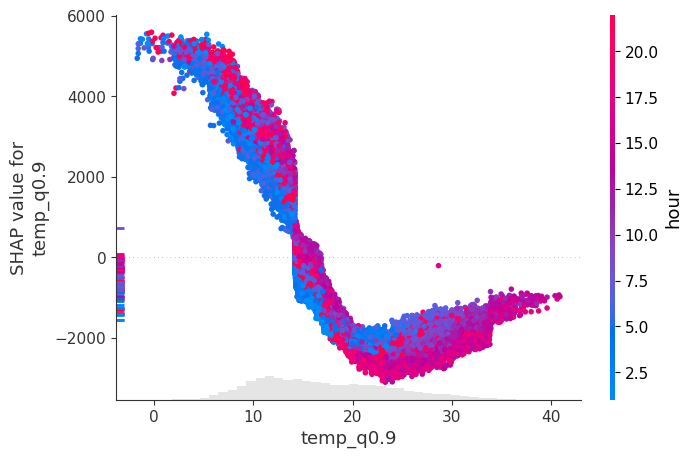

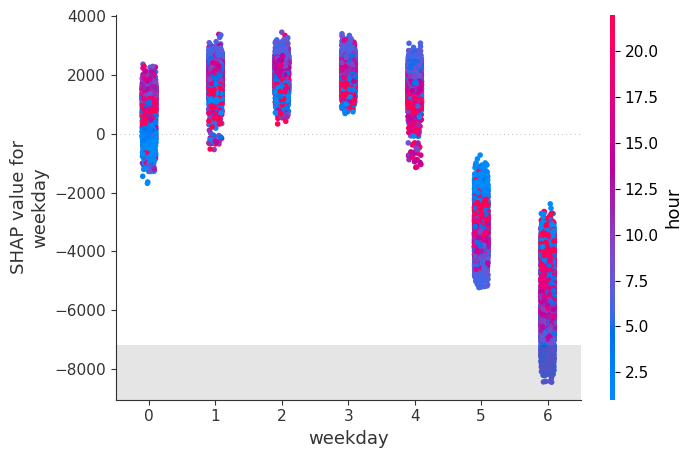

In [19]:
tsn.xgb.scatter(shap_values=shap_values, feature='hour')
tsn.xgb.scatter(shap_values=shap_values, feature='month')
tsn.xgb.scatter(shap_values=shap_values, feature='temp_q0.9')
tsn.xgb.scatter(shap_values=shap_values, feature='weekday')